Minimal Surface Equation: $\left(1+z_{x}^{2}\right)z_{yy}-2z_{x}z_{y}z_{xy}+\left(1+z_{y}^{2}\right)z_{xx}=0$

Boundary conditions: 
$
z(-1,:) = 1-y^2\\
z(1,:) = 1-y^2\\
z(:,-1) = 0\\
z(:,1) = 0 \\
$


In [20]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "5"
import numpy as np
import jax.numpy as jnp
from jax import vmap, jit
import scipy as sp
from scipy.integrate import odeint
import scipy
import jax


N=50
xgrid = jnp.linspace(-1,1,N)
xygrid = jnp.stack(jnp.meshgrid(xgrid,xgrid),axis=-1)
dx = xgrid[1]-xgrid[0]

@jit
def pde_deriv(z):
    deriv = lambda x: jax.scipy.signal.correlate(x,jnp.array([-1/2,0,1/2])/dx,mode='same')
    deriv2 = lambda x: jax.scipy.signal.correlate(x,jnp.array([1.,-2,1.])/dx**2,mode='same')
    zx,zy = [jnp.apply_along_axis(deriv,i,z) for i in [0,1]]
    zxx,zyy = [jnp.apply_along_axis(deriv2,i,z) for i in [0,1]]
    zxy  = jnp.apply_along_axis(deriv,1,zx)
    return (1+zx**2)*zyy-2*zx*zy*zxy+(1+zy**2)*zxx

x,y = xygrid.transpose((2,0,1))
domain = (jnp.abs(x)<1)&(jnp.abs(y)<1)
boundary_vals = np.zeros_like(x)
boundary_vals[:,0] = 1-y[:,0]**2
boundary_vals[:,-1] = 1-y[:,-1]**2

@jit
def pde_op(u):
    padded_domain = jnp.zeros(boundary_vals.shape)+boundary_vals
    padded_domain = padded_domain.at[domain].set(u.reshape(-1))
    padded_domain = pde_deriv(padded_domain)
    return padded_domain[domain].reshape(u.shape)

@jit
def J_matvec(u,v):
    return jax.jvp(pde_op,(u,),(v,))[1]

J = lo.jacobian(pde_op,u)

#from scipy.sparse.linalg import LinearOperator, eigsh

#matmat = vmap(pde_op,-1,-1)

#L = LinearOperator(2*(domain.sum(),),matvec = pde_op,rmatvec = pde_op,matmat=matmat,rmatmat=matmat,dtype=np.float32)

In [4]:
from functools import partial
from scipy.sparse.linalg import LinearOperator
# Newton Raphson iteration
z = jnp.zeros_like(x[domain]).reshape(-1)
tol = 1e-3
err = np.inf
while err > tol:
    Jmvm = partial(J_matvec,z)
    J = LinearOperator(2*(domain.sum(),),matvec = Jmvm,matmat=jit(vmap(Jmvm,-1,-1)),dtype=np.float32)
    F = pde_op(z)
    err = jnp.max(jnp.abs(F))
    delta,info = scipy.sparse.linalg.gmres(J,-F,tol=1e-5)
    z += delta
    print(f"PDE Error: {err:1.1e}, Update size: {jnp.linalg.norm(delta):1.1e}, info: {info}")
    #print(info,jnp.linalg.norm(delta),jnp.linalg.norm(z),err)
    

PDE Error: 6.0e+02, Update size: 1.2e+01, info: 0
PDE Error: 2.7e+02, Update size: 1.0e+01, info: 0
PDE Error: 3.4e+02, Update size: 2.2e+00, info: 0
PDE Error: 8.8e+01, Update size: 1.8e-01, info: 0
PDE Error: 1.5e+01, Update size: 1.5e-02, info: 0
PDE Error: 4.1e-01, Update size: 2.7e-04, info: 0
PDE Error: 4.3e-04, Update size: 5.4e-06, info: 0


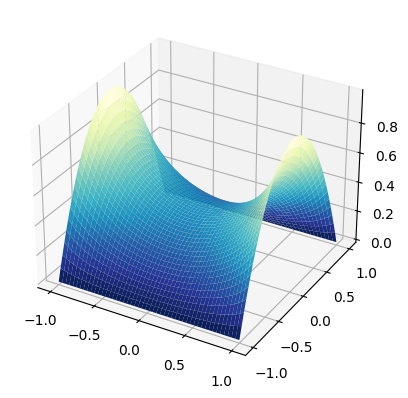

In [7]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
img = jnp.zeros(boundary_vals.shape)+boundary_vals
img = img.at[domain].set(z)
ax.plot_surface(x, y, img, cmap=plt.cm.YlGnBu_r)
plt.show()

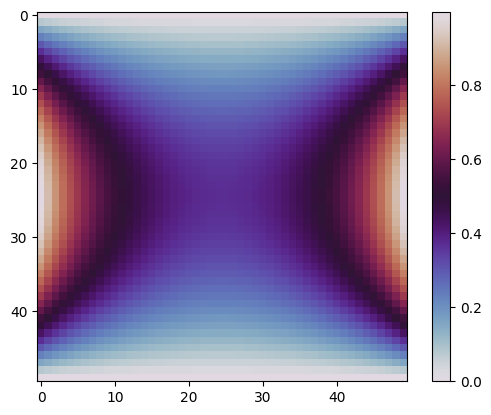

In [8]:
plt.imshow(img,cmap='twilight')
plt.colorbar()
plt.show()

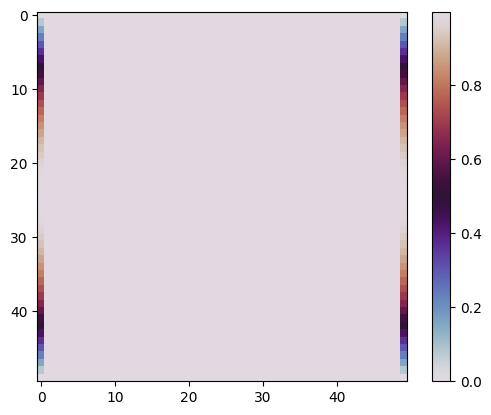

In [9]:
plt.imshow(boundary_vals.reshape(x.shape),cmap='twilight')
plt.colorbar()

In [21]:
z2 = jnp.zeros_like(x[domain]).reshape(-1)
Jmvm = partial(J_matvec,z2)
J = LinearOperator(2*(domain.sum(),),matvec = Jmvm,matmat=jit(vmap(Jmvm,-1,-1)),dtype=np.float32)

In [22]:
JJ = J@jnp.eye(J.shape[0])

In [23]:
jnp.max(jnp.abs(JJ.T -JJ))

DeviceArray(64.500015, dtype=float32)

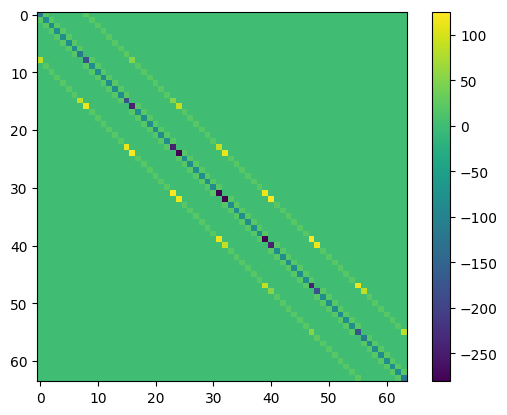

In [26]:
plt.imshow(JJ)
plt.colorbar()

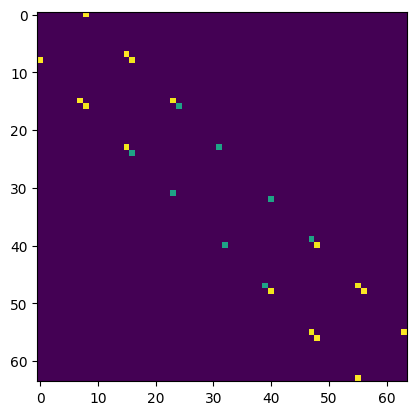

In [24]:
plt.imshow(jnp.abs(JJ.T -JJ))

In [19]:
jnp.where(jnp.abs(JJ.T -JJ)>1e-3)

(DeviceArray([   0,   47,   48,   48,   95,   95,   96,   96,  143,  143,
               144,  144,  191,  191,  192,  192,  239,  239,  240,  240,
               287,  287,  288,  288,  335,  335,  336,  336,  383,  383,
               384,  384,  431,  431,  432,  432,  479,  479,  480,  480,
               527,  527,  528,  528,  575,  575,  576,  576,  623,  623,
               624,  624,  671,  671,  672,  672,  719,  719,  720,  720,
               767,  767,  768,  768,  815,  815,  816,  816,  863,  863,
               864,  864,  911,  911,  912,  912,  959,  959,  960,  960,
              1007, 1007, 1008, 1008, 1055, 1055, 1056, 1056, 1103, 1103,
              1104, 1151, 1152, 1199, 1200, 1200, 1247, 1247, 1248, 1248,
              1295, 1295, 1296, 1296, 1343, 1343, 1344, 1344, 1391, 1391,
              1392, 1392, 1439, 1439, 1440, 1440, 1487, 1487, 1488, 1488,
              1535, 1535, 1536, 1536, 1583, 1583, 1584, 1584, 1631, 1631,
              1632, 1632, 1679, 1679, 